- Analise e responda qual foi o crescimento das vendas (VendasSupermercados) dos últimos 12 meses (Set/2022 - Agosto 2023 vs Set/2021 - Agosto 2022)?
- Analise e responda se existe sazonalidade e tendência nesses dados? Como você descreveria e mostraria graficamente?
- Analise e responda se existe relação entre o CDI e as vendas? Como você a descreveria e mostraria graficamente?

# Importando Bibliotecas

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Carregando Dataset

In [98]:
df = pd.read_csv("Data/VendasSupermercadosCDI.csv", sep=";")
df.head()

,Date,VendasSupermercados,CDI
0,2010-01-01,76.39,0.66
1,2010-02-01,73.95,0.59
2,2010-03-01,81.69,0.76
3,2010-04-01,77.91,0.66
4,2010-05-01,78.66,0.75


## Descrição das Features

O dataset possui três colunas 
- **Date:** Representa o mês e ano das vendas no supermercado
- **VendasSupermercados:** Vendas do supermercado naquele mês
- **CDI:** Valor do CDI (Certificado de Depósito Interbancário) naquele mês

# Engenharia de Variáveis

In [99]:
# função que converte a feature Date para datetime
def convert_date_column(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    return df

convert_date_column(df, 'Date')

# função que cria uma coluna de trimestres
def trimester_column(df, date_column):
    df['Trimestre'] = df[date_column].dt.to_period("Q")
    return df

df = trimester_column(df, 'Date')

# função que cria uma coluna de vendas por trimestre
def calculate_sales_per_trimester(df, sales_column):
    df['VendasPorTrimestre'] = df.groupby('Trimestre')[sales_column].transform('sum')
    return df

df = calculate_sales_per_trimester(df, 'VendasSupermercados')

# Cria uma coluna com os anos das vendas
def year_column(df, date_column):
    df['Ano'] = df[date_column].dt.year
    return df

df = year_column(df, 'Date')

# Calcula a as vendas por ano
def calculate_sales_per_year(df, sales_column):
    df['VendasPorAno'] = df.groupby('Ano')[sales_column].transform('sum')
    return df

df = calculate_sales_per_year(df, 'VendasSupermercados')

# Calcula a taxa de vendas por valor do cdi
def sales_per_cdi_column(df, vendas_column, cdi_column):
    df['VendasPorCDI'] = df[vendas_column] / df[cdi_column]
    return df

df = sales_per_cdi_column(df, 'VendasSupermercados', 'CDI')

df['Trimestre'] = df['Trimestre'].astype(str)
df.head()

,Date,VendasSupermercados,CDI,Trimestre,VendasPorTrimestre,Ano,VendasPorAno,VendasPorCDI
0,2010-01-01,76.39,0.66,2010Q1,232.03,2010,970.47,115.742424
1,2010-02-01,73.95,0.59,2010Q1,232.03,2010,970.47,125.338983
2,2010-03-01,81.69,0.76,2010Q1,232.03,2010,970.47,107.486842
3,2010-04-01,77.91,0.66,2010Q2,233.47,2010,970.47,118.045455
4,2010-05-01,78.66,0.75,2010Q2,233.47,2010,970.47,104.880000


In [100]:
print(df.Date.max())
print(df.Date.min())

2023-08-01 00:00:00
2010-01-01 00:00:00


Vemos que o intervalo entre a primeira e a última data de vendas do dataset é de aproximadamente 13 anos e meio. Além disso, devemos nos atentar para o fato da série temporal de 2023 está incompleta o que afeta a análise

In [101]:
df_train = df[(df['Date'] < '2023-07-01') & (df['Date'] > '2023-03-01')]
df_test = df[df['Date'] < '2023-04-01']
print(df_train.Date.max())
print(df_train.Date.min())


2023-06-01 00:00:00
2023-04-01 00:00:00


Dividindo os dados logo no ínicio da análise para evitar vazamento e simular o ambiente real

# Análise Exploratória de Dados

In [102]:
df_train.columns

Index(['Date', 'VendasSupermercados', 'CDI', 'Trimestre', 'VendasPorTrimestre',
       'Ano', 'VendasPorAno', 'VendasPorCDI'],
      dtype='object')

In [103]:
# Analisando as dimensões do dataset
df.shape

(164, 8)

O dataset possui poucas linhas e colunas, então buscaremos criar mais variáveis para melhorar o modelo final

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 164 non-null    datetime64[ns]
 1   VendasSupermercados  164 non-null    float64       
 2   CDI                  164 non-null    float64       
 3   Trimestre            164 non-null    object        
 4   VendasPorTrimestre   164 non-null    float64       
 5   Ano                  164 non-null    int32         
 6   VendasPorAno         164 non-null    float64       
 7   VendasPorCDI         164 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int32(1), object(1)
memory usage: 9.7+ KB


As features não possuem valores ausentes. As **VendasSupermercados** e **CDI** estão num formato correto, porém a **Date** precisar ser transformado para datetime

In [105]:
df.describe()

,Date,VendasSupermercados,CDI,VendasPorTrimestre,Ano,VendasPorAno,VendasPorCDI
count,164,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,2016-10-15 19:19:01.463414528,93.174329,0.738537,278.254085,2016.341463,1098.547317,167.135756
min,2010-01-01 00:00:00,73.950000,0.130000,208.100000,2010.000000,801.330000,72.017241
25%,2013-05-24 06:00:00,88.070000,0.537500,265.607500,2013.000000,1071.680000,94.318651
50%,2016-10-16 12:00:00,91.700000,0.785000,276.460000,2016.000000,1120.310000,116.249590
75%,2020-03-08 18:00:00,97.612500,0.952500,296.820000,2020.000000,1143.540000,176.345486
max,2023-08-01 00:00:00,122.750000,1.210000,327.600000,2023.000000,1211.920000,747.625000
std,NaN,9.001255,0.281626,23.128121,3.960602,93.788564,133.404225


Vemos que a média e mediana das **VendasSupermercados** estão próximas, isso pode indicar uma distribuição mais simétrica dos dados e provavelmente pouca presença de outliers. Além disso, o desvio padrão do **CDI** está em quase 40% da média do **CDI** o que indica uma variabilidade considerável

In [106]:
df.nunique(axis=0)

Date                   164
VendasSupermercados    152
CDI                     75
Trimestre               55
VendasPorTrimestre      54
Ano                     14
VendasPorAno            14
VendasPorCDI           164
dtype: int64

Percebemos que não há datas repitidas, porém alguns dias com o mesmo número de vendas da mesma forma do CDI

In [107]:
df.VendasSupermercados.value_counts()

VendasSupermercados
87.41     2
97.68     2
94.48     2
89.43     2
84.39     2
         ..
92.38     1
89.01     1
116.78    1
96.75     1
104.75    1
Name: count, Length: 152, dtype: int64

In [108]:
df.CDI.value_counts()

CDI
0.54    8
1.11    6
0.86    6
0.84    5
1.07    5
       ..
1.00    1
1.21    1
1.08    1
0.50    1
1.14    1
Name: count, Length: 75, dtype: int64

isso confirma o que falamos acima e vemos quais os valores com repeticões e quais os mais repitidos

In [109]:
df.duplicated().sum()

0

Não temos nenhuma linha duplicada

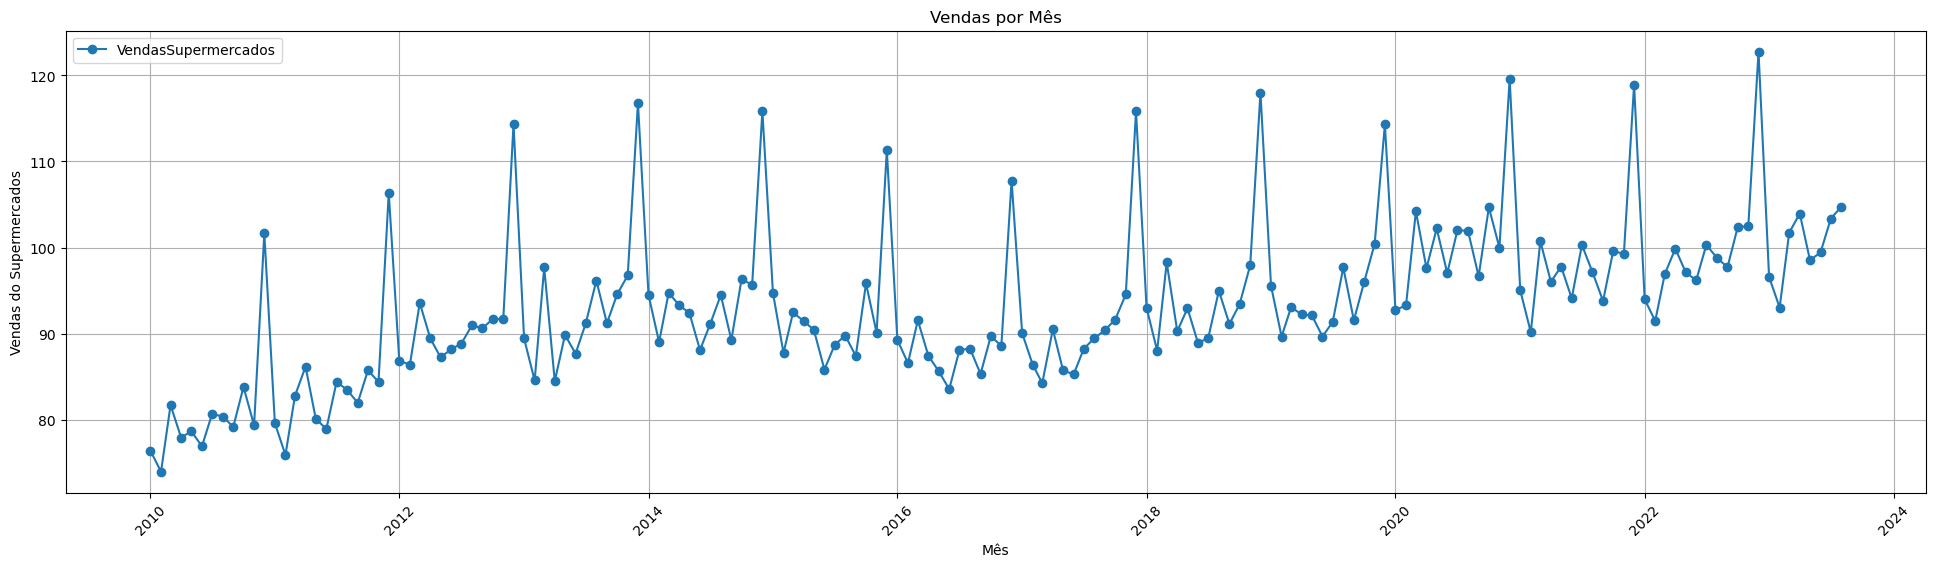

In [110]:
df = df.sort_values(by='Date')

plt.figure(figsize=(24, 6))
plt.plot(df['Date'], df['VendasSupermercados'], label='VendasSupermercados', marker='o')
plt.title('Vendas por Mês')
plt.xlabel('Mês')
plt.ylabel('Vendas do Supermercados')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

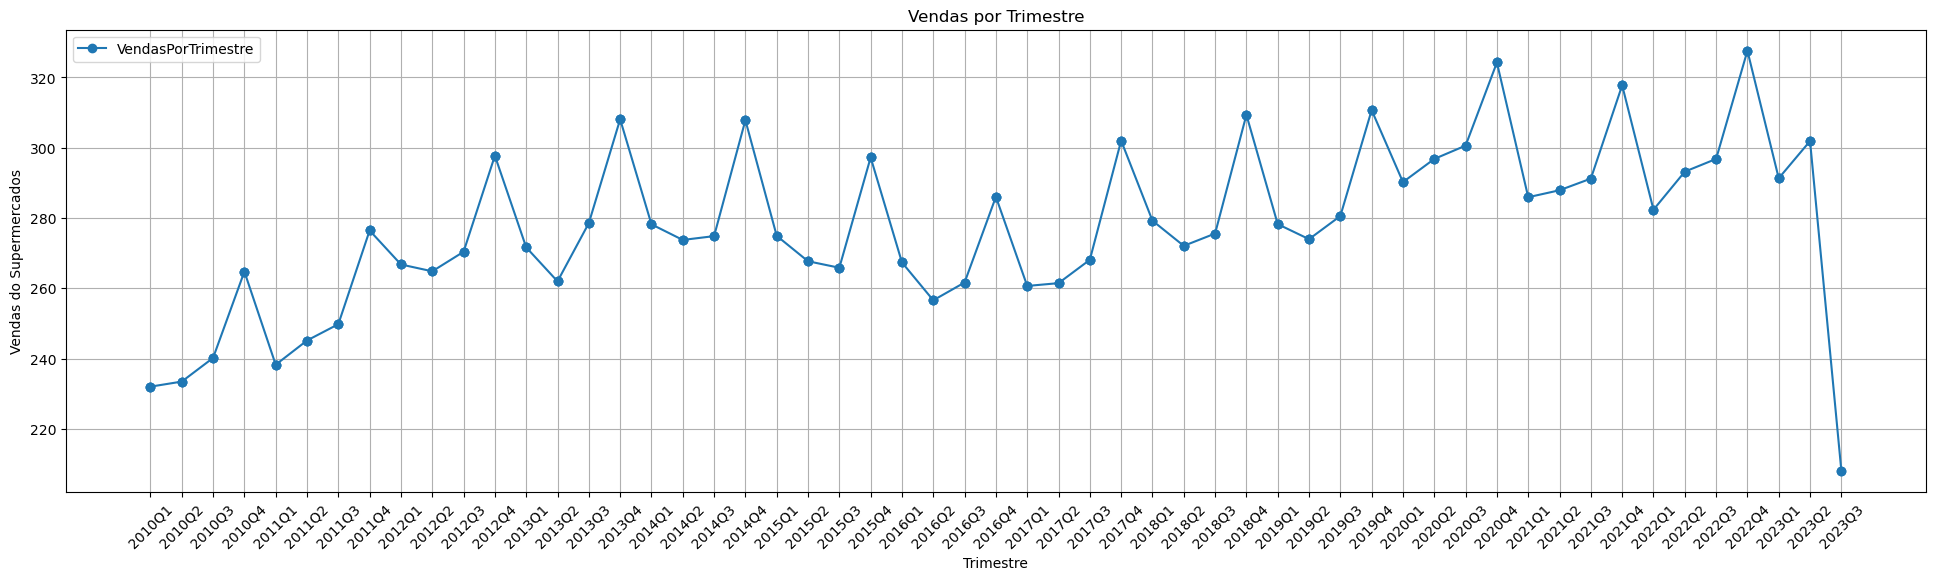

In [111]:
df = df.sort_values(by='Trimestre')

plt.figure(figsize=(24, 6))
plt.plot(df['Trimestre'], df['VendasPorTrimestre'], label='VendasPorTrimestre', marker='o')
plt.title('Vendas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Vendas do Supermercados')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

O gráfico acima mostra uma tendência no cresimento das vendas do começo ao final de cada ano, com um crescimeto mais acentuado no último trimestre do ano, provavelmente devido as festas de final de ano e black friday

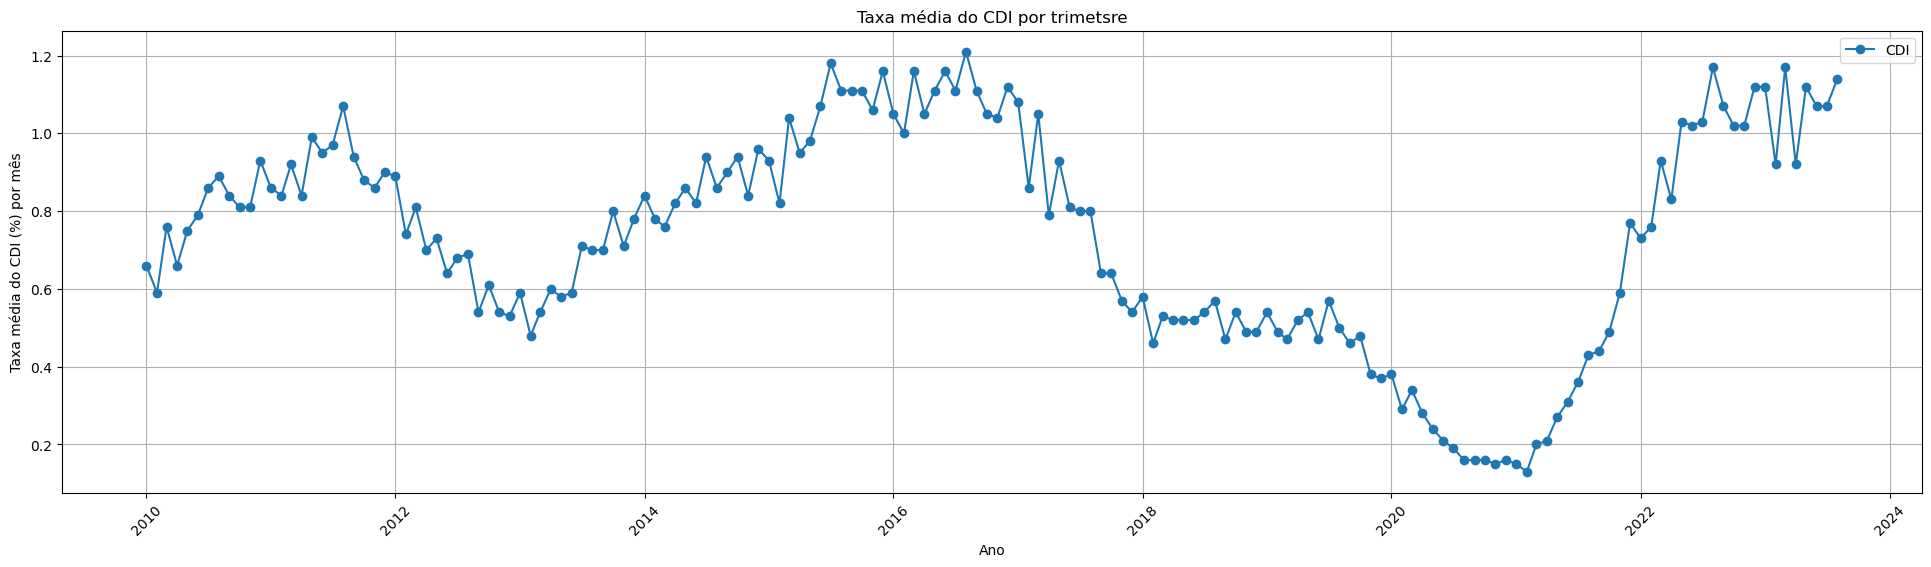

In [112]:
df = df.sort_values(by='Date')

plt.figure(figsize=(24, 6))
plt.plot(df['Date'], df['CDI'], label='CDI', marker='o')
plt.title('Taxa média do CDI por trimetsre')
plt.xlabel('Ano')
plt.ylabel('Taxa média do CDI (%) por mês')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [113]:
# Selecionando os últimos 12 meses 
last_12_months = df[(df['Date'] >= '2022-09-01') & (df['Date'] <= '2023-08-31')]

# selecionando os 12 meses anteriores
previous_12_months = df[(df['Date'] >= '2021-09-01') & (df['Date'] <= '2022-08-31')]

# calculando o total de vendas nos últimos 12 meses
sales_last_12_months = last_12_months['VendasSupermercados'].sum()

# calculando as vendas nos 12 meses anteriores
sales_previous_12_months = previous_12_months['VendasSupermercados'].sum()

# Calculando a porcentagem do crescimento de vendas dos últimos 12 meses em comparação aos 12 meses anteriores
sales_increase_percentage = ((sales_last_12_months / sales_previous_12_months) -1) * 100

print(f'O aumento de vendas dos últimos 12 meses em comparação aos 12 meses anteriores foi de {sales_increase_percentage:.2f}%.')

O aumento de vendas dos últimos 12 meses em comparação aos 12 meses anteriores foi de 3.41%.


KeyError: 'MediaCDITrimestral'

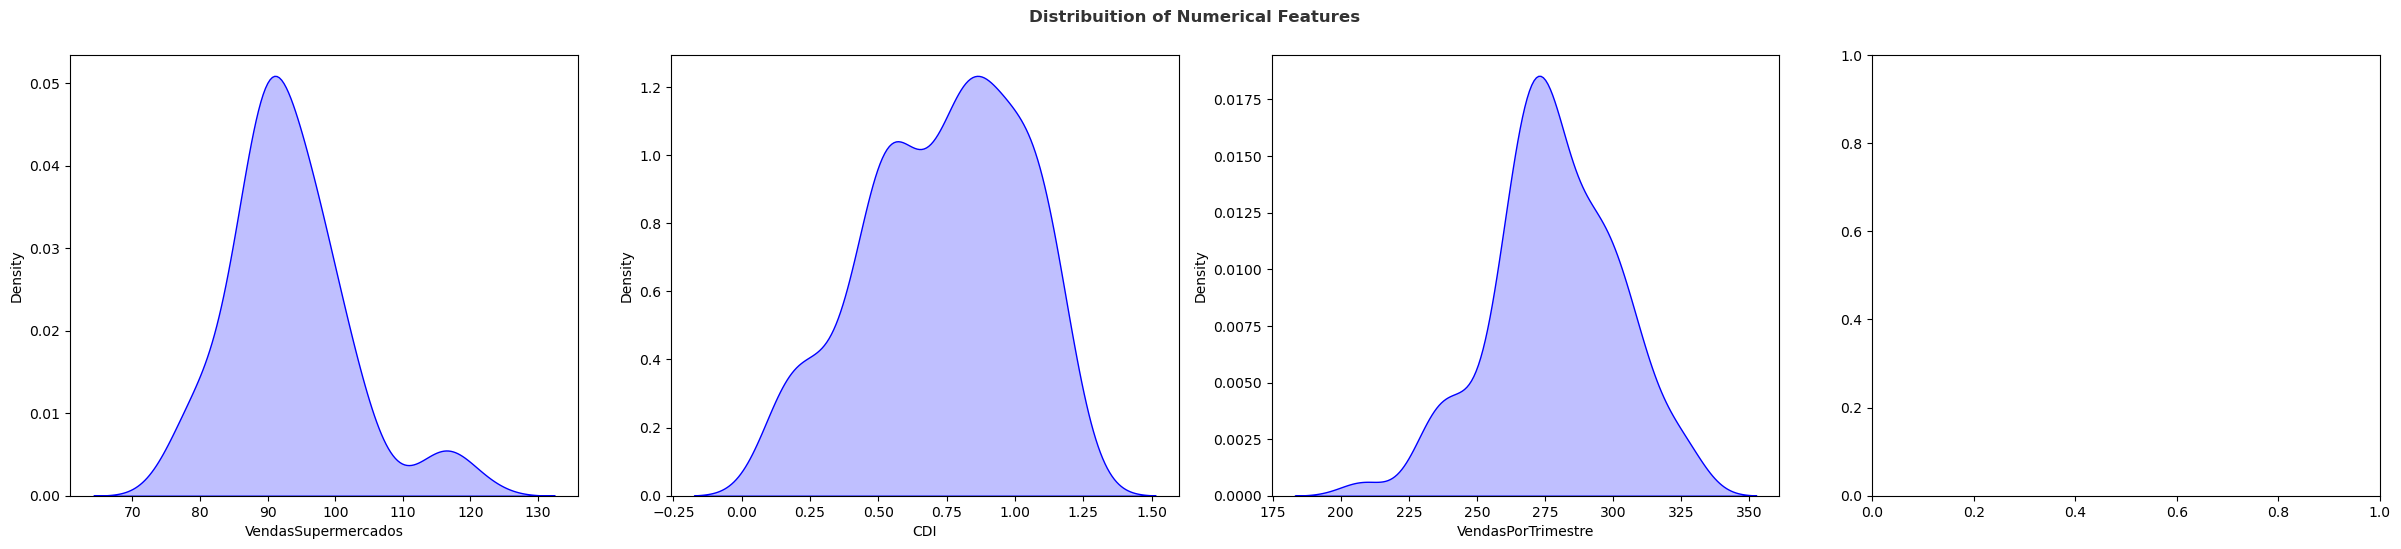

In [114]:
numerical_features = ['VendasSupermercados', 'CDI', 'VendasPorTrimestre', 'MediaCDITrimestral']

plt.figure(figsize=(24, 10))
plt.suptitle('Distribuition of Numerical Features', fontsize=12, fontweight='bold', alpha=0.8, y=1.)
for i in range(len(numerical_features)):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(x=df[numerical_features[i]], shade=True, color='b')
    plt.xlabel(numerical_features[i])
    plt.tight_layout()

# Modelo